In [156]:
# Import
import datetime as dt
import pandas as pd
import numpy as np
from datetime import timedelta
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, aic
import statsmodels.api as sm
from pmdarima import auto_arima
from arch import arch_model
import seaborn as sns
from sklearn.metrics import mean_squared_error

## Data Preprocessinng

In [2]:
# reading csv file of weather data
wt_df = pd.read_csv(r"data/weather_data.csv")
wt_df = wt_df.drop(['Unnamed: 0'], axis=1)
wt_df

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
0,Admiralty,2014,1,1,0.0,0.0,0.0,0.0,26.3,28.8,24.3,10.8,34.2
1,Admiralty,2014,1,2,0.0,0.0,0.0,0.0,26.9,30.7,24.6,11.5,38.2
2,Admiralty,2014,1,3,4.6,4.4,4.4,4.6,26.5,29.5,24.9,9.7,34.2
3,Admiralty,2014,1,4,3.8,3.8,3.8,3.8,26.4,31.2,24.7,8.1,32.8
4,Admiralty,2014,1,5,3.6,1.2,1.6,2.0,24.6,25.3,23.6,8.4,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89893,Whampoa,2018,12,27,0.0,0.0,0.0,0.0,,,,,
89894,Whampoa,2018,12,28,0.0,0.0,0.0,0.0,,,,,
89895,Whampoa,2018,12,29,0.0,0.0,0.0,0.0,,,,,
89896,Whampoa,2018,12,30,0.4,0.4,0.4,0.4,,,,,


In [3]:
# reading csv file of weekly dengue cases data
dg_df = pd.read_csv(r"data/weekly-number-of-cases.csv")

# dengue dataframe
dg_df.dropna(inplace=True)
dg_df

,year,eweek,type_dengue,number
0,2014,1,Dengue,436.0
1,2014,1,DHF,1.0
2,2014,2,Dengue,479.0
3,2014,2,DHF,0.0
4,2014,3,Dengue,401.0
...,...,...,...,...
523,2018,50,DHF,1.0
524,2018,51,Dengue,127.0
525,2018,51,DHF,1.0
526,2018,52,Dengue,160.0


In [4]:
# adding Dengue and DHF cases and then reset index to save the sum to dataframe
d_df = dg_df.groupby(['year','eweek'])['number'].sum().reset_index()
d_df

,year,eweek,number
0,2014,1,437.0
1,2014,2,479.0
2,2014,3,401.0
3,2014,4,336.0
4,2014,5,234.0
...,...,...,...
256,2018,48,109.0
257,2018,49,114.0
258,2018,50,108.0
259,2018,51,128.0


In [5]:
d_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    261 non-null    int64  
 1   eweek   261 non-null    int64  
 2   number  261 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 6.2 KB


In [6]:
wt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89898 entries, 0 to 89897
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Station                        89898 non-null  object
 1   Year                           89898 non-null  int64 
 2   Month                          89898 non-null  int64 
 3   Day                            89898 non-null  int64 
 4   Daily Rainfall Total (mm)      89898 non-null  object
 5   Highest 30 Min Rainfall (mm)   89898 non-null  object
 6   Highest 60 Min Rainfall (mm)   89898 non-null  object
 7   Highest 120 Min Rainfall (mm)  89898 non-null  object
 8   Mean Temperature (°C)          89898 non-null  object
 9   Maximum Temperature (°C)       89769 non-null  object
 10  Minimum Temperature (°C)       89757 non-null  object
 11  Mean Wind Speed (km/h)         89898 non-null  object
 12  Max Wind Speed (km/h)          89731 non-null  object
dtypes

In [7]:
# data cleaning and transformation
df_obj = wt_df.select_dtypes(['object'])
# stripe empty space before tranform data types to numeric
wt_df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
# wt_df[df_obj.columns] = df_obj.apply(lambda x: float(x.str.split()[0].replace('\x97', '')))
wt_df = wt_df.replace('\x97', '')
wt_df = wt_df.replace(r'^\s*$', np.nan, regex=True)


In [8]:
wt_df

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
0,Admiralty,2014,1,1,0.0,0.0,0.0,0.0,26.3,28.8,24.3,10.8,34.2
1,Admiralty,2014,1,2,0.0,0.0,0.0,0.0,26.9,30.7,24.6,11.5,38.2
2,Admiralty,2014,1,3,4.6,4.4,4.4,4.6,26.5,29.5,24.9,9.7,34.2
3,Admiralty,2014,1,4,3.8,3.8,3.8,3.8,26.4,31.2,24.7,8.1,32.8
4,Admiralty,2014,1,5,3.6,1.2,1.6,2.0,24.6,25.3,23.6,8.4,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89893,Whampoa,2018,12,27,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
89894,Whampoa,2018,12,28,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
89895,Whampoa,2018,12,29,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
89896,Whampoa,2018,12,30,0.4,0.4,0.4,0.4,NaN,NaN,NaN,NaN,NaN


In [9]:
# data transformation
wt_df['Daily Rainfall Total (mm)'] = wt_df['Daily Rainfall Total (mm)'].astype(float)
wt_df['Mean Temperature (°C)'] = wt_df['Mean Temperature (°C)'].astype(float)
wt_df['Mean Wind Speed (km/h)'] = wt_df['Mean Wind Speed (km/h)'].astype(float)

In [10]:
# Remove NUll ??? --> No need since group by will ignore NaN by default
wt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89898 entries, 0 to 89897
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Station                        89898 non-null  object 
 1   Year                           89898 non-null  int64  
 2   Month                          89898 non-null  int64  
 3   Day                            89898 non-null  int64  
 4   Daily Rainfall Total (mm)      87337 non-null  float64
 5   Highest 30 Min Rainfall (mm)   80439 non-null  object 
 6   Highest 60 Min Rainfall (mm)   80439 non-null  object 
 7   Highest 120 Min Rainfall (mm)  80439 non-null  object 
 8   Mean Temperature (°C)          31063 non-null  float64
 9   Maximum Temperature (°C)       33619 non-null  object 
 10  Minimum Temperature (°C)       33605 non-null  object 
 11  Mean Wind Speed (km/h)         34551 non-null  float64
 12  Max Wind Speed (km/h)          34269 non-null 

In [11]:
# add a dataframe field

wt_df["Year"] = wt_df["Year"].astype(str)
wt_df["Month"] = wt_df["Month"].astype(str)
wt_df["Day"] = wt_df["Day"].astype(str)

wt_df["Date"] = pd.to_datetime(wt_df["Year"] + "/" + wt_df["Month"] + "/" + wt_df["Day"])
wt_df

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Date
0,Admiralty,2014,1,1,0.0,0.0,0.0,0.0,26.3,28.8,24.3,10.8,34.2,2014-01-01
1,Admiralty,2014,1,2,0.0,0.0,0.0,0.0,26.9,30.7,24.6,11.5,38.2,2014-01-02
2,Admiralty,2014,1,3,4.6,4.4,4.4,4.6,26.5,29.5,24.9,9.7,34.2,2014-01-03
3,Admiralty,2014,1,4,3.8,3.8,3.8,3.8,26.4,31.2,24.7,8.1,32.8,2014-01-04
4,Admiralty,2014,1,5,3.6,1.2,1.6,2.0,24.6,25.3,23.6,8.4,27.0,2014-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89893,Whampoa,2018,12,27,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-12-27
89894,Whampoa,2018,12,28,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-12-28
89895,Whampoa,2018,12,29,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-12-29
89896,Whampoa,2018,12,30,0.4,0.4,0.4,0.4,NaN,NaN,NaN,NaN,NaN,2018-12-30


In [12]:
# add a week number field to be join key with dengue dataframe
wt_df['Week_Number'] = wt_df['Date'].dt.isocalendar().week
wt_df

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Date,Week_Number
0,Admiralty,2014,1,1,0.0,0.0,0.0,0.0,26.3,28.8,24.3,10.8,34.2,2014-01-01,1
1,Admiralty,2014,1,2,0.0,0.0,0.0,0.0,26.9,30.7,24.6,11.5,38.2,2014-01-02,1
2,Admiralty,2014,1,3,4.6,4.4,4.4,4.6,26.5,29.5,24.9,9.7,34.2,2014-01-03,1
3,Admiralty,2014,1,4,3.8,3.8,3.8,3.8,26.4,31.2,24.7,8.1,32.8,2014-01-04,1
4,Admiralty,2014,1,5,3.6,1.2,1.6,2.0,24.6,25.3,23.6,8.4,27.0,2014-01-05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89893,Whampoa,2018,12,27,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-12-27,52
89894,Whampoa,2018,12,28,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-12-28,52
89895,Whampoa,2018,12,29,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,2018-12-29,52
89896,Whampoa,2018,12,30,0.4,0.4,0.4,0.4,NaN,NaN,NaN,NaN,NaN,2018-12-30,52


In [13]:
wt_df['Week_year']= wt_df['Year'].astype(int)

In [14]:
wt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89898 entries, 0 to 89897
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Station                        89898 non-null  object        
 1   Year                           89898 non-null  object        
 2   Month                          89898 non-null  object        
 3   Day                            89898 non-null  object        
 4   Daily Rainfall Total (mm)      87337 non-null  float64       
 5   Highest 30 Min Rainfall (mm)   80439 non-null  object        
 6   Highest 60 Min Rainfall (mm)   80439 non-null  object        
 7   Highest 120 Min Rainfall (mm)  80439 non-null  object        
 8   Mean Temperature (°C)          31063 non-null  float64       
 9   Maximum Temperature (°C)       33619 non-null  object        
 10  Minimum Temperature (°C)       33605 non-null  object        
 11  Mean Wind Speed

In [15]:
wt_df['Week_year'] = wt_df.apply(lambda row: row['Week_year']+1 if ((row['Month']=='12') and (row['Week_Number']==1)) else row['Week_year'],  axis=1)
wt_df[(wt_df['Month']=='12') & (wt_df['Week_Number']==1)]

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Date,Week_Number,Week_year
332,Admiralty,2014,12,29,1.0,1.0,1.0,1.0,25.2,28.2,24.1,13.3,50.0,2014-12-29,1,2015
333,Admiralty,2014,12,30,0.0,0.0,0.0,0.0,24.8,26.0,23.9,12.1,45.7,2014-12-30,1,2015
334,Admiralty,2014,12,31,0.0,0.0,0.0,0.0,25.9,28.1,24.4,11.2,36.7,2014-12-31,1,2015
697,Ang Mo Kio,2014,12,29,3.0,2.2,2.2,2.6,25.5,29.0,23.6,8.4,37.8,2014-12-29,1,2015
698,Ang Mo Kio,2014,12,30,0.0,0.0,0.0,0.0,25.0,26.5,24.1,7.1,28.4,2014-12-30,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88437,Tuas South,2018,12,31,5.0,3.8,3.8,3.8,27.5,31.3,25.3,7.2,31.3,2018-12-31,1,2019
88802,Tuas West,2018,12,31,9.4,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,2018-12-31,1,2019
89167,Ulu Pandan,2018,12,31,51.4,32.0,42.8,50.6,NaN,NaN,NaN,NaN,NaN,2018-12-31,1,2019
89532,Upper Peirce Reservoir,2018,12,31,9.6,5.4,6.4,6.8,NaN,NaN,NaN,NaN,NaN,2018-12-31,1,2019


In [16]:
w_df = wt_df.groupby(['Week_year','Week_Number']).agg({'Daily Rainfall Total (mm)' : 'mean', 'Mean Temperature (°C)' : 'mean', 'Mean Wind Speed (km/h)': 'mean'}).reset_index()
w_df['week'] = w_df['Week_Number'].astype(int)
w_df['year'] = w_df['Week_year'].astype(int)
w_df = w_df.drop('Week_Number', axis=1)
w_df = w_df.drop('Week_year', axis=1)
w_df

,Daily Rainfall Total (mm),Mean Temperature (°C),Mean Wind Speed (km/h),week,year
0,4.013191,26.521429,8.748889,1,2014
1,7.426140,26.502521,7.839683,2,2014
2,0.023708,26.245378,12.849206,3,2014
3,0.000000,25.783193,12.439683,4,2014
4,0.000000,26.210256,12.272222,5,2014
...,...,...,...,...,...
258,9.385890,27.361905,5.721368,49,2018
259,12.300313,26.844954,6.608264,50,2018
260,3.454955,27.990000,7.391870,51,2018
261,0.769697,28.495327,8.190083,52,2018


In [17]:
df = pd.merge(w_df, d_df,  how='left', left_on = ['year','week'], right_on = ['year','eweek'])
df = df.drop('eweek', axis=1)
# rename columns
df = df.rename(columns={'Daily Rainfall Total (mm)': 'avg rainfall', 'Mean Temperature (°C)': 'avg temperature', 'Mean Wind Speed (km/h)':'avg wind speed'})
df.dropna(inplace=True)
# Determine the date
df['date'] = pd.to_datetime(df.assign(day=1, month=1)[['year', 'month', 'day']])+pd.to_timedelta(df.week*7, unit='days')

# diff data
data = df[['avg rainfall','avg temperature','avg wind speed','number','date']]
data.set_index('date', inplace=True)
data = data.diff().dropna()

# Time Series Analysis


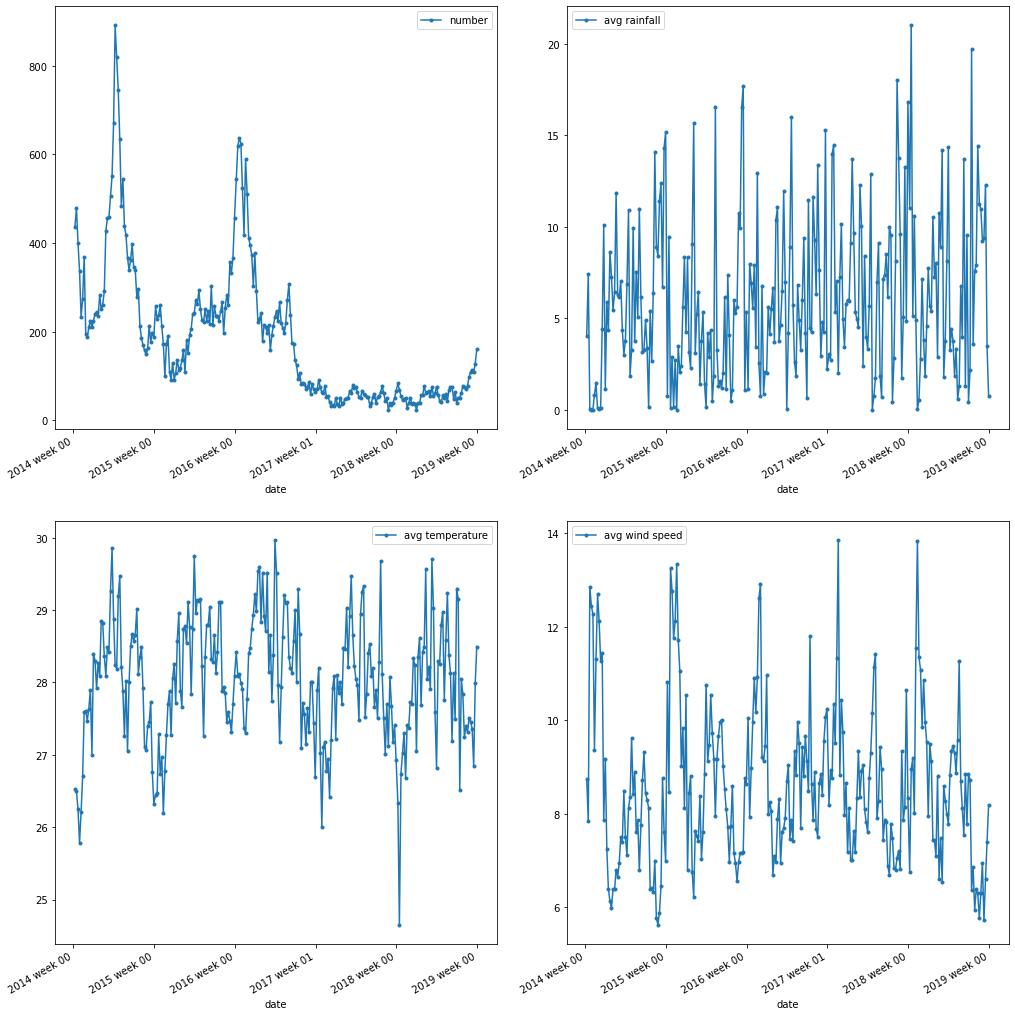

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot
fig, ax = plt.subplots(2,2,figsize=(15, 15))
df.plot(x='date', y='number', marker='.', ax=ax[0,0])
df.plot(x='date', y='avg rainfall', marker='.', ax=ax[0,1])
df.plot(x='date', y='avg temperature', marker='.', ax=ax[1,0])
df.plot(x='date', y='avg wind speed', marker='.', ax=ax[1,1])

fig.tight_layout(pad=5.0)

# Format the x-ticks
myFmt = mdates.DateFormatter('%Y week %U')
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].xaxis.set_major_formatter(myFmt)

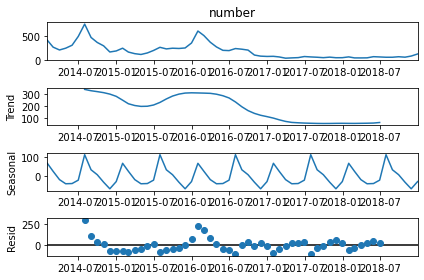

In [19]:
df.set_index('date', inplace=True)

y_m = df['number'].resample('M').mean()
result = seasonal_decompose(y_m, model='additive') # additive
fig = result.plot()

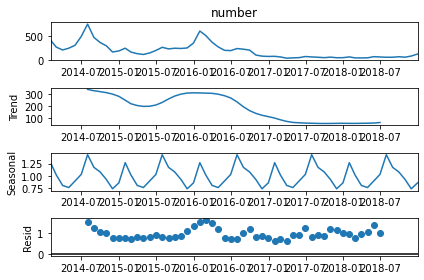

In [20]:
result = seasonal_decompose(y_m, model='multiplicative') # multiplicative
fig = result.plot()

### Findings: 
Time serires is seasonal. Thus, SARIMA is suitable.

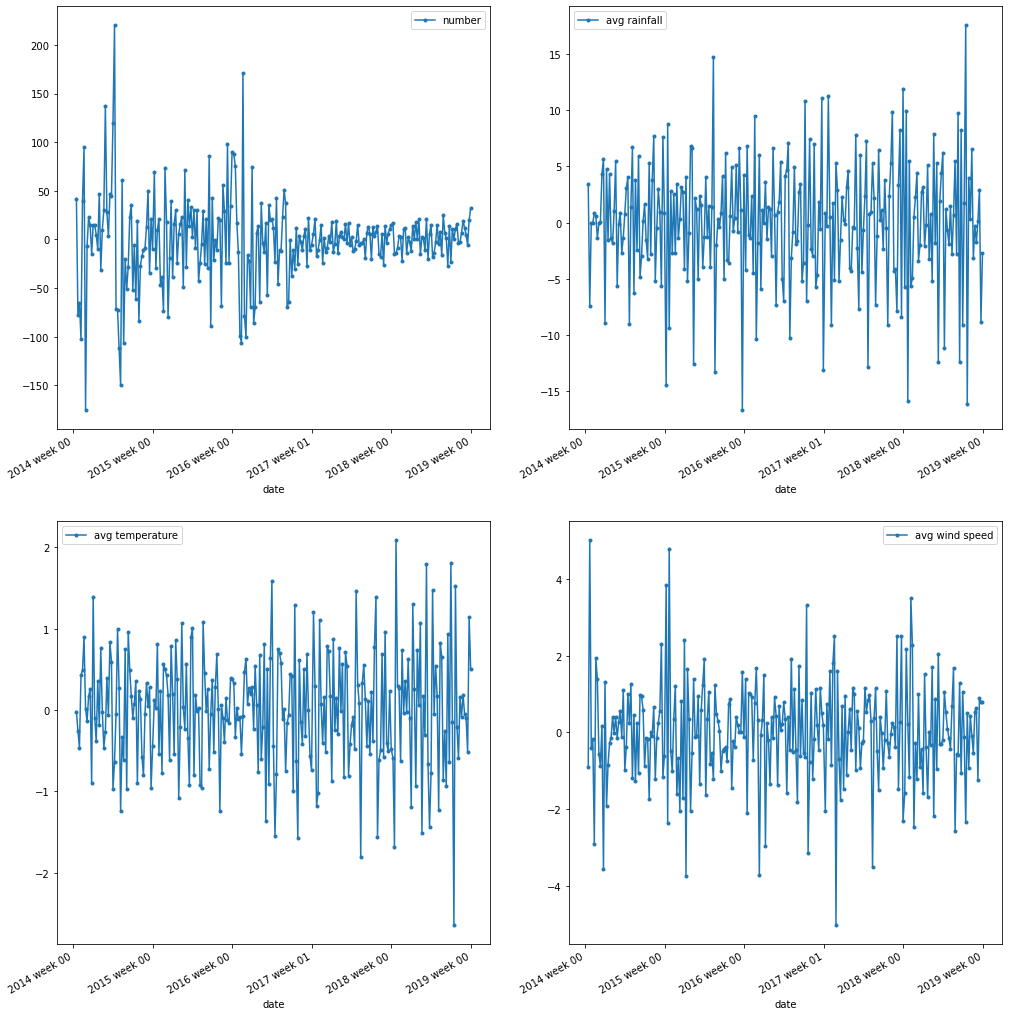

In [21]:
# Plot to check if diff data series is stationary

fig, ax = plt.subplots(2,2,figsize=(15, 15))
data.plot( y='number',use_index=True, marker='.', ax=ax[0,0])
data.plot( y='avg rainfall',use_index=True, marker='.', ax=ax[0,1])
data.plot( y='avg temperature',use_index=True, marker='.', ax=ax[1,0])
data.plot( y='avg wind speed',use_index=True, marker='.', ax=ax[1,1])

fig.tight_layout(pad=5.0)

# Format the x-ticks
myFmt = mdates.DateFormatter('%Y week %U')
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].xaxis.set_major_formatter(myFmt)

### Granger Causality Test to investigate causality of data. 

Granger causality is a way to investigate the causality between two variables in a time series which actually means if a particular variable comes before another in the time series. In the MTS, we will test the causality of all combinations of pairs of variables.

##### Granger Causality Hypothesis:
* H0 (Null Hypothesis) : lagged x-values do not explain the variation in y, so the x does not cause y. 
* H1 (Alternative Hypothesis) : x causes y

We use grangercausalitytests function in the package statsmodels to do the test and the output of the matrix is the minimum p-value when computes the test for all lags up to maxlag(=22). The critical value we use is 5% and if the p-value of a pair of variables is smaller than 0.05, we could say with 95% confidence that a predictor x causes a response y.

In [22]:
from statsmodels.tsa.stattools import grangercausalitytests

variables=data.columns  
matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
maxlag=22

for col in matrix.columns:
    for row in matrix.index:
        test_result = grangercausalitytests(data[[row, col]], maxlag=24, verbose=False)            
        p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(maxlag)]            
        min_p_value = np.min(p_values)
        matrix.loc[row, col] = min_p_value
matrix.columns = [var + '_x' for var in variables]
matrix.index = [var + '_y' for var in variables]

matrix

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,avg rainfall_x,avg temperature_x,avg wind speed_x,number_x
avg rainfall_y,1.0000,0.0070,0.0002,0.0848
avg temperature_y,0.2498,1.0000,0.7440,0.4155
avg wind speed_y,0.0000,0.0000,1.0000,0.0844
number_y,0.0052,0.0901,0.0149,1.0000


#### Findings:
From the result above, each column represents a predictor x of each variable and each row represents the response y and the p-value of each pair of variables are shown in the matrix.
 
Take the value 0.0052 (<0.05) in (row 3, column 1) and 0.0149 (<0.05) in (row 3, column 3):

Because  p<0.05, we reject H0 (x-values do not explain the variation in y). In other words, it suggests that avg rainfall and avg wind speed is causal to avg dengue case numbers !

Thus Vector Arima could be helpful to modelling this time series.

### Stationary Test
As VectorARIMA requires time series to be stationary, we will use one popular statistical test – Augmented Dickey-Fuller Test (ADF Test) to check the stationary of each variable in the dataset.  

The Null Hypothesis is that the data has unit root and is not stationary and the significant value is 0.05.

In [83]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 5) 
    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")
        
for name, column in data.iteritems():
    adfuller_test(column, name=column.name)

 avg rainfall : P-Value = 0.0 => Stationary. 
 avg temperature : P-Value = 0.0 => Stationary. 
 avg wind speed : P-Value = 0.0 => Stationary. 
 number : P-Value = 1e-05 => Stationary. 


#### Findings:
From the results above, we could see none of these varibles is stationary. Let us use the differencing method to make them stationary.

In [24]:
df

,avg rainfall,avg temperature,avg wind speed,week,year,number
date,,,,,,
2014-01-08,4.013191,26.521429,8.748889,1,2014,437.0
2014-01-15,7.426140,26.502521,7.839683,2,2014,479.0
2014-01-22,0.023708,26.245378,12.849206,3,2014,401.0
2014-01-29,0.000000,25.783193,12.439683,4,2014,336.0
2014-02-05,0.000000,26.210256,12.272222,5,2014,234.0
...,...,...,...,...,...,...
2018-12-03,9.253235,27.456250,6.954032,48,2018,109.0
2018-12-10,9.385890,27.361905,5.721368,49,2018,114.0
2018-12-17,12.300313,26.844954,6.608264,50,2018,108.0


In [25]:
data

,avg rainfall,avg temperature,avg wind speed,number
date,,,,
2014-01-15,3.412948,-0.018908,-0.909206,42.0
2014-01-22,-7.402432,-0.257143,5.009524,-78.0
2014-01-29,-0.023708,-0.462185,-0.409524,-65.0
2014-02-05,0.000000,0.427063,-0.167460,-102.0
2014-02-12,0.821277,0.493105,-2.900794,40.0
...,...,...,...,...
2018-12-03,-1.711202,-0.050172,0.644941,12.0
2018-12-10,0.132654,-0.094345,-1.232665,5.0
2018-12-17,2.914423,-0.516951,0.886897,-6.0


In [26]:
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [27]:
#data.index = data.index.to_period('W')
data

,avg rainfall,avg temperature,avg wind speed,number
date,,,,
2014-01-15,3.412948,-0.018908,-0.909206,42.0
2014-01-22,-7.402432,-0.257143,5.009524,-78.0
2014-01-29,-0.023708,-0.462185,-0.409524,-65.0
2014-02-05,0.000000,0.427063,-0.167460,-102.0
2014-02-12,0.821277,0.493105,-2.900794,40.0
...,...,...,...,...
2018-12-03,-1.711202,-0.050172,0.644941,12.0
2018-12-10,0.132654,-0.094345,-1.232665,5.0
2018-12-17,2.914423,-0.516951,0.886897,-6.0


## Train-Test Split

In [28]:
test_obs = int(len(data) * 0.2)
train = data[:-test_obs]
test = data[-test_obs:]

# for ARIMA
endog = train[['number']]
exog = train[['avg rainfall','avg temperature','avg wind speed']]
test_exog = data[-test_obs:][['avg rainfall','avg temperature','avg wind speed']]

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


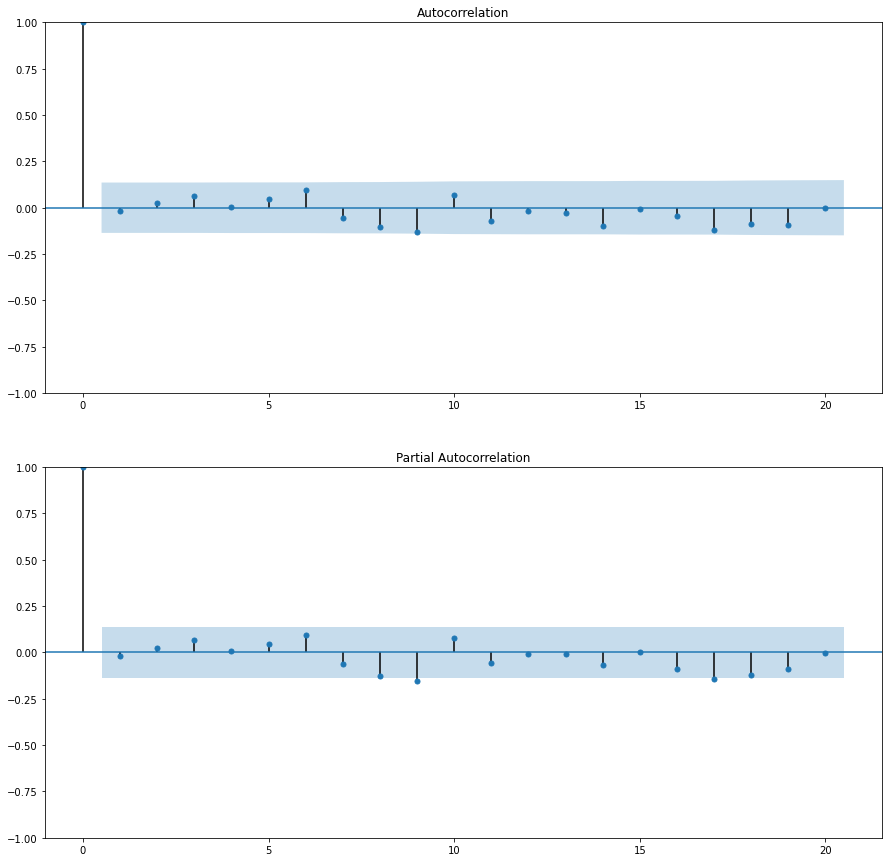

In [29]:
# Generate autocorrelation plot on training data.
fig, ax = plt.subplots(2,1,figsize=(15, 15))
plot_acf(train['number'], lags = 20,ax=ax[0]);
plot_pacf(train['number'], lags = 20,ax=ax[1]);

#### Findings: 
Both the ACF and PACF show a gradual decay, an ARMA model is likely appropriate as opposed to AR or MA alone. Since there are multiple variables, I will use vector ARIMA model to fit data.

## Model

### Vector Auto Regression (VAR)
https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/#:~:text=A%20Multivariate%20time%20series%20has,used%20for%20forecasting%20future%20values.

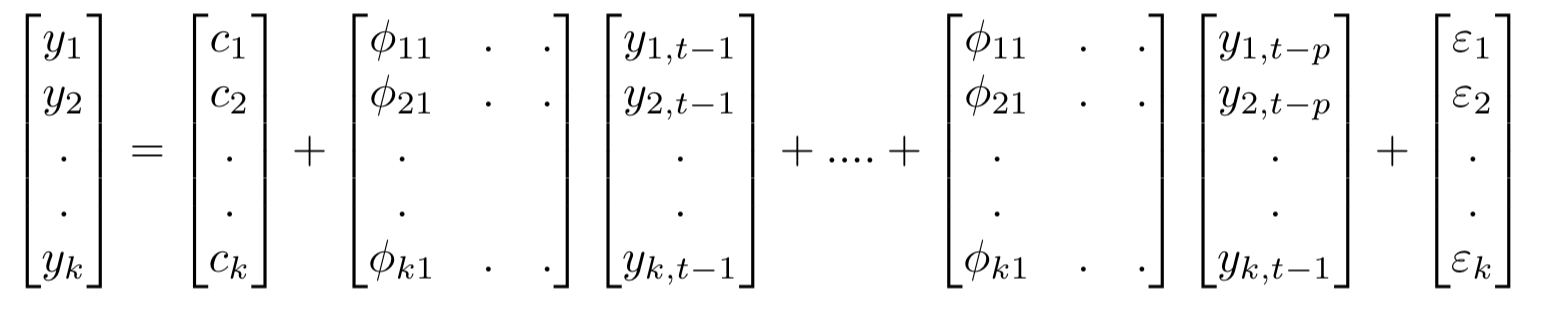

In [30]:
model = VAR(train)

/Users/zhangzhexu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [31]:
x = model.select_order(maxlags=16)
x.summary()

,AIC,BIC,FPE,HQIC
0,10.05,10.12*,2.309e+04,10.07
1,9.806,10.15,1.814e+04,9.943
2,9.674,10.28,1.591e+04,9.922*
3,9.604,10.49,1.484e+04,9.961
4,9.573*,10.73,1.440e+04*,10.04
5,9.574,11.00,1.444e+04,10.15
6,9.600,11.30,1.485e+04,10.29
7,9.618,11.59,1.517e+04,10.41
8,9.701,11.94,1.656e+04,10.61
9,9.781,12.29,1.805e+04,10.80


In [32]:
results_aic = []
results_bic = []
results_hqic = []
for p in range(1,10):
    results = model.fit(p)
    results_aic.append(results.aic)
    results_bic.append(results.bic)
    results_hqic.append(results.hqic)

Text(0, 0.5, 'HQIC')

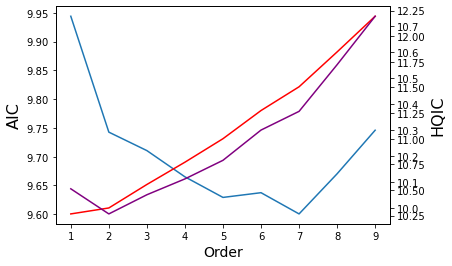

In [33]:
#define subplots
fig,ax = plt.subplots()
#add first line to plot
ax.plot(list(np.arange(1,10,1)), results_aic)
#add x-axis label
ax.set_xlabel('Order', fontsize=14)
#add y-axis label
ax.set_ylabel('AIC', fontsize=16)

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()
#add second line to plot
ax2.plot(list(np.arange(1,10,1)), results_bic, color='red')
#add second y-axis label
ax2.set_ylabel('BIC', fontsize=16)

#define third y-axis that shares x-axis with current plot
ax3 = ax.twinx()
#add third line to plot
ax3.plot(list(np.arange(1,10,1)), results_hqic, color ='Purple')
#add third y-axis label
ax2.set_ylabel('HQIC', fontsize=16)

In [34]:
p = 7
#p = 6
results =  model.fit(p)
# results.summary()

In [35]:
# make predictions
pred = results.forecast(results.endog, steps = test_obs)
pred = pd.DataFrame(pred, columns = data.columns + '_pred')
#pred

In [36]:
d = data.tail(test_obs)
pred.index = d.index

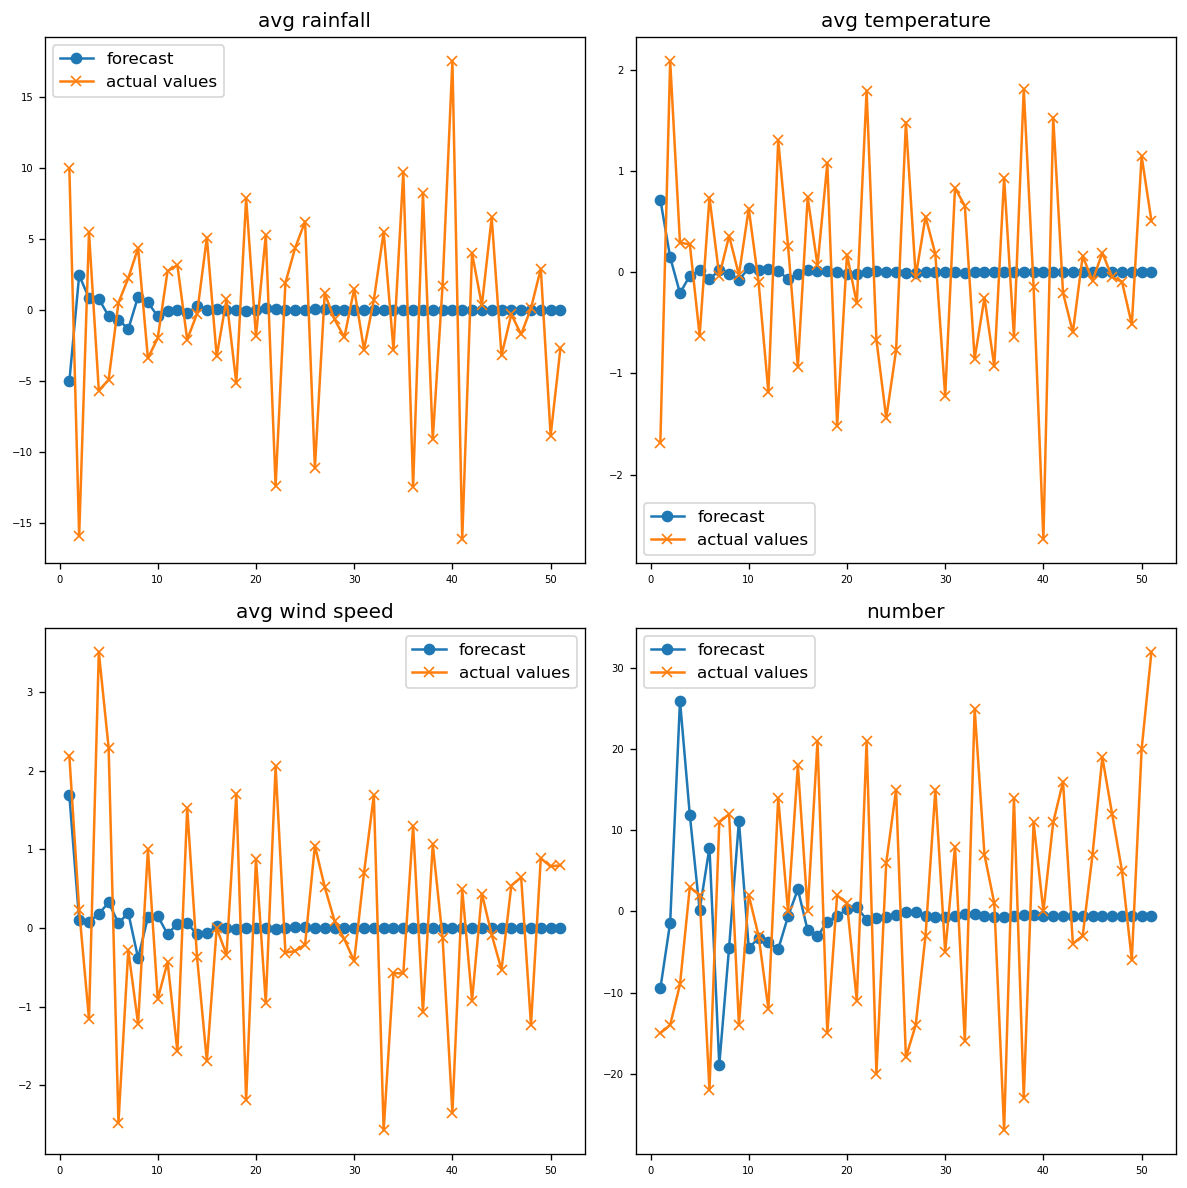

In [37]:
def plot_forecast_actuals(data, data_actual, data_predict):
    fig, axes = plt.subplots(nrows=int(len(data_actual.columns)/2), ncols=2, dpi=120, figsize=(8,5))
    for i, (col,ax) in enumerate(zip(data_actual.columns, axes.flatten())):
        ax.plot(list(np.arange(1,test_obs+1,1)),data_predict[col + '_pred'], label='forecast', marker='o')
        ax.plot(list(np.arange(1,test_obs+1,1)),data_actual[col], label='actual values', marker='x')
        ax.legend(loc='best')
        ax.set_title(data.columns[i])
        ax.set_title(col)
        ax.tick_params(labelsize=6)
    
    plt.tight_layout();
    
plot_forecast_actuals(data=data, data_actual=test, data_predict = pred)

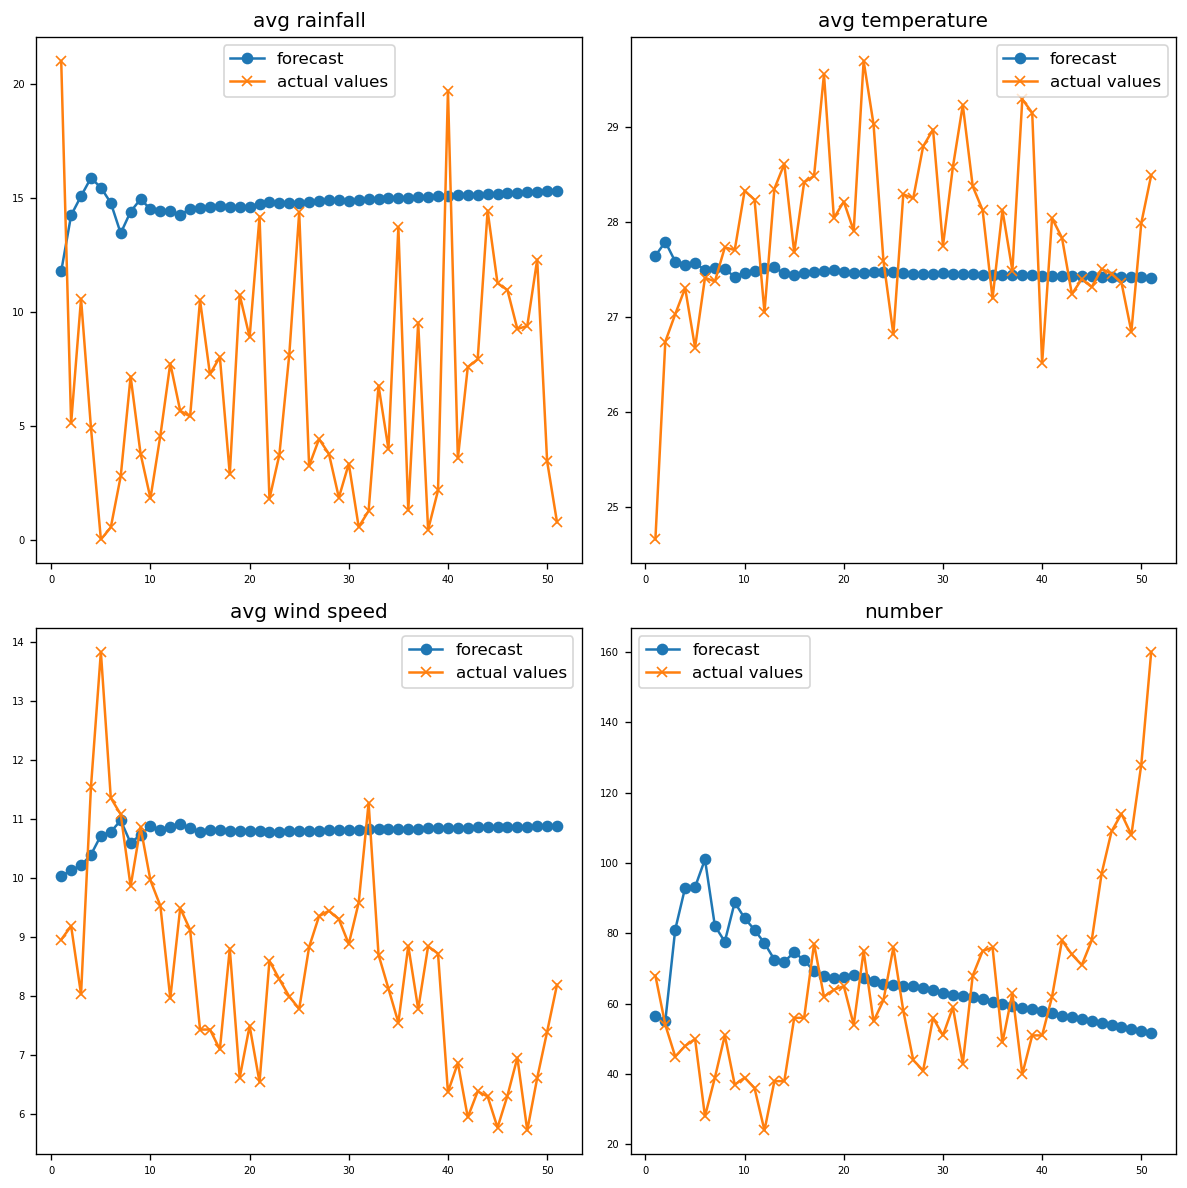

In [38]:
def invert_transformation(endog_train,pred):
    forecast = pred.copy()
    columns = endog_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = endog_train[col].iloc[-1] +   forecast[str(col) +'_pred'].cumsum()
    return forecast

output = invert_transformation( df[['avg rainfall','avg temperature','avg wind speed','number']].head(len(df)-test_obs-1), pred)

plot_forecast_actuals(data=data, data_actual=df[['avg rainfall','avg temperature','avg wind speed','number']].tail(test_obs), data_predict = output)

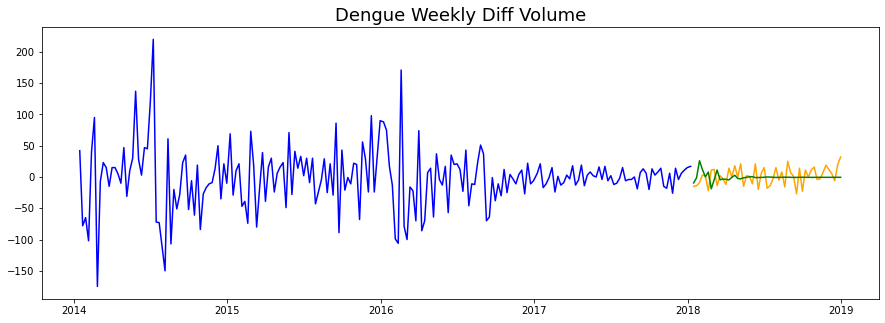

In [39]:
# Plot data.
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot training data in blue.
plt.plot(train['number'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['number'], color = 'orange')

# Plot predicted values in green.
plt.plot(pred['number_pred'], color = 'green')

plt.title(label = 'Dengue Weekly Diff Volume', fontsize=18)
plt.show();

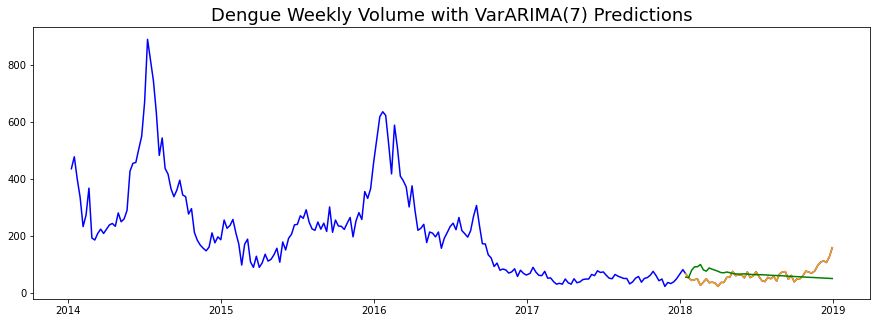

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(df['number'], color = 'blue')
plt.plot(df['number'].tail(test_obs), color = 'orange')
plt.plot(output['number_pred'], color = 'green')         
plt.title(label = f'Dengue Weekly Volume with VarARIMA({p}) Predictions', fontsize=18)
plt.show();

In [41]:
# Evaluate predictions.
mean_squared_error(test['number'], pred['number_pred'])

251.8032862397474

In [42]:
mean_squared_error(df['number'][-test_obs:], output['number_pred'])

1170.040451584093

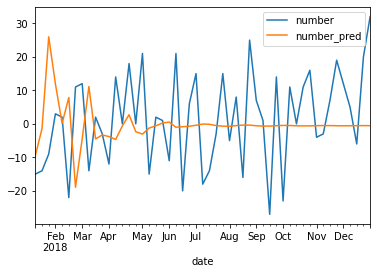

In [144]:
res1 =  pd.concat([test,pred['number_pred']],axis=1)
res1[['number','number_pred']].plot()
res1['diff'] = res1['number']-res1['number_pred']


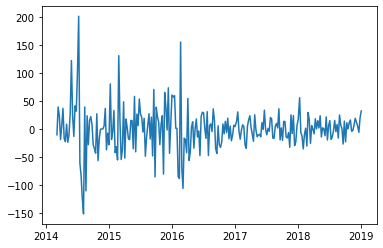

In [150]:
# residual plot
var_res = pd.concat([results.resid['number'], res1['diff']])
plt.plot(var_res)

## Findings:
The residual plot depicts variance change, which indicates that model variance is not constant over time.
To tackle with conditional variance, we will use GARCH model (arch package in python). 

## ARIMA (Poor perfomance model)

In [43]:
import warnings
warnings.filterwarnings("ignore")

#p=9
#q=[9,17]
#i=[1,2]
# Starting AIC, p, and q.
best_aic = float('inf')
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(8):
    for q in range(8):
        
        # Instantiate ARIMA model.
        arima = ARIMA(endog = endog, exog = exog, order=(p, 1, q))
        
        
        # Fit ARIMA model.
        model = arima.fit()

        # Is my current model's AIC better than our best_aic?
        if model.aic < best_aic:
            
            # If so, let's overwrite best_aic, best_p, and best_q.
            best_aic = model.aic
            best_p = p
            best_q = q


        #except:
            #print('err')
            #pass
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,1).
This model has an AIC of 2209.1013878035.


In [44]:
ma1 = ARIMA(endog = endog, exog = exog, order=(best_p, 1, best_q))
model = ma1.fit()

# Generate predictions based on test set.
preds = model.predict(exog = test_exog, start=len(data)-test_obs, end=len(data)-1)

# Evaluate predictions.
mean_squared_error(test['number'], preds)

201.52445356421296

In [45]:
pred1 = preds.to_frame()
pred1 = pred1.rename(columns= {'predicted_mean': 'number_pred'})
pred1.index = d.index
#pred1

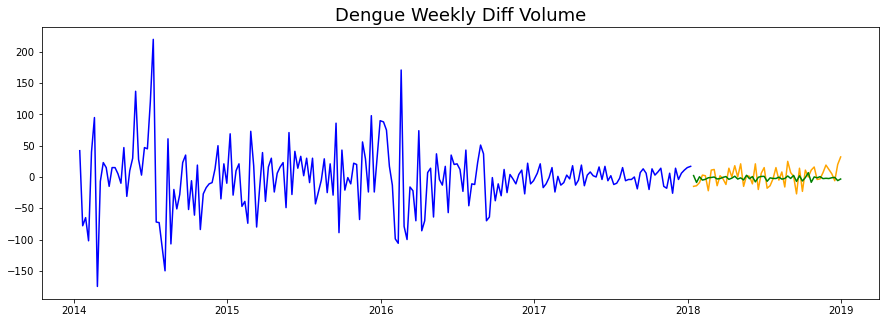

In [46]:
# Plot data.
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot training data in blue.
plt.plot(train['number'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['number'], color = 'orange')

# Plot predicted values in green.
plt.plot(pred1['number_pred'], color = 'green')

plt.title(label = 'Dengue Weekly Diff Volume', fontsize=18)
plt.show();

In [47]:

outputs1 = invert_transformation(endog, pred1)

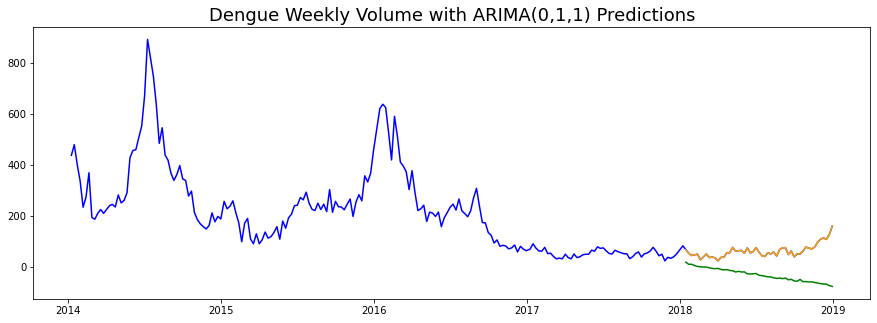

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(df['number'], color = 'blue')
plt.plot(df['number'].tail(test_obs), color = 'orange')
plt.plot(outputs1, color = 'green')         
plt.title(label = f'Dengue Weekly Volume with ARIMA({best_p},1,{best_q}) Predictions', fontsize=18)
plt.show();

In [49]:
mean_squared_error(df['number'][-test_obs:], outputs1)

10836.740854393649

## Findins:
From the plot we can see ARIMA performs poorly and predicts rediculous results.

## SARIMA

In [105]:
sarima_model1 = auto_arima(
                        y=endog, 
                        X=exog,
                        start_p=1, 
                        start_q=1,
                        max_p=8, 
                        max_q=8, 
                        m=4,    # quaterly
                        start_P=0, 
                        max_P = 4,
                        max_Q = 4,
						seasonal=True,
                        d=1, 
                        #D=1, 
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=2349.758, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=2287.823, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=2347.759, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=2286.072, Time=0.09 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=2287.728, Time=0.18 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=2288.157, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[4] intercept   : AIC=2258.562, Time=0.16 sec
 ARIMA(2,1,0)(1,0,0)[4] intercept   : AIC=2260.477, Time=0.31 sec
 ARIMA(2,1,0)(0,0,1)[4] intercept   : AIC=2260.451, Time=0.29 sec
 ARIMA(2,1,0)(1,0,1)[4] intercept   : AIC=2259.467, Time=0.30 sec
 ARIMA(3,1,0)(0,0,0)[4] intercept   : AIC=2247.801, Time=0.25 sec
 ARIMA(3,1,0)(1,0,0)[4] intercept   : AIC=2240.566, Time=0.37 sec
 ARIMA(3,1,0)(2,0,0)[4] intercept   : AIC=2

In [106]:
sarima_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  208
Model:             SARIMAX(3, 1, 0)x(4, 0, 0, 4)   Log Likelihood               -1102.436
Date:                           Sat, 24 Dec 2022   AIC                           2226.871
Time:                                   04:49:54   BIC                           2263.531
Sample:                                        0   HQIC                          2241.696
                                           - 208                                         
Covariance Type:                             opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
avg rainfall        0.2007      0.823      0.244      0.807      -1.413       1.814
avg temperature     0.1717      7.319      0.023      0.981     -14.174      14.517
avg wind speed     -0.6329      2.819     -0.225      0.822      -6.158       4.892
ar.L1              -0.9488      0.045    -20.975      0.000      -1.037      -0.860
ar.L2              -0.7742      0.058    -13.372      0.000      -0.888      -0.661
ar.L3              -0.6628      0.062    -10.606      0.000      -0.785      -0.540
ar.S.L4            -0.5973      0.081     -7.374      0.000      -0.756      -0.439
ar.S.L8            -0.4769      0.090     -5.323      0.000      -0.652      -0.301
ar.S.L12           -0.2650      0.094     -2.807      0.005      -0.450      -0.080
ar.S.L16           -0.1571      0.083     -1.895      0.058      -0.320       0.005
sigma2           2451.3710    178.421     13.739      0.000    2101.671    2801.071
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                42.41
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Findings
According to the model summary, the model meets the condition of independence in the residuals (no correlation) because the p-value of the Ljung-Box test (Prob(Q)) is not greater than 0.05, so we reject the null hypothesis of independence, which means the residual distribution is not homoscedastic (constant variance) because the p-value of the Heteroskedasticity test (Prob(H)) is 0, smaller than 0.05.

In [107]:
forecast,confint = sarima_model1.predict(n_periods= test_obs, X = test_exog, return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['number_pred'])
forecast.index=test.index
#forecast

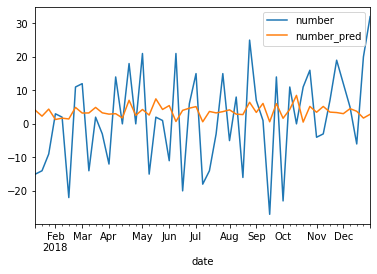

In [108]:
res = pd.concat([test,forecast],axis=1)
res[['number','number_pred']].plot()
res['diff'] = res['number']-res['number_pred']


In [109]:
pred2 = invert_transformation(endog, res[['number_pred']])
cf= pd.DataFrame(confint)

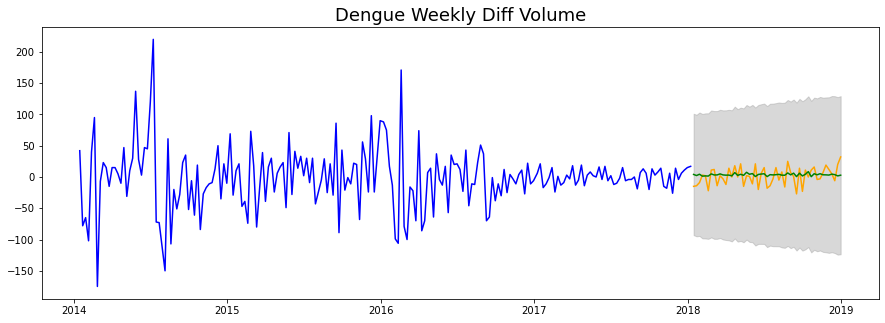

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot training data in blue.
plt.plot(train['number'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['number'], color = 'orange')

# Plot predicted values in green.
plt.plot(res['number_pred'], color = 'green')

ax.fill_between(forecast.index,
                cf[0],
                cf[1],color='grey',alpha=.3)
                
plt.title(label = 'Dengue Weekly Diff Volume', fontsize=18)
plt.show();

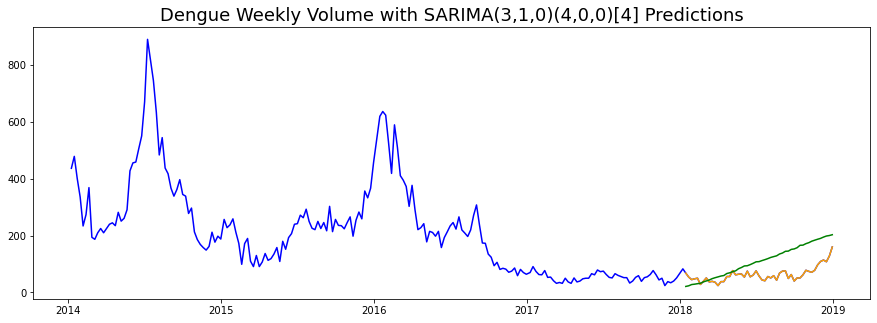

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

plt.plot(df['number'], color = 'blue')
plt.plot(df['number'].tail(test_obs), color = 'orange')
plt.plot(pred2, color = 'green')
      
plt.title(label = f'Dengue Weekly Volume with SARIMA(3,1,0)(4,0,0)[4] Predictions', fontsize=18)
plt.show();

In [112]:
mean_squared_error(test['number'], res[['number_pred']])

185.73481506863675

In [113]:
mean_squared_error(df['number'][-test_obs:], pred2)

4031.735355041466

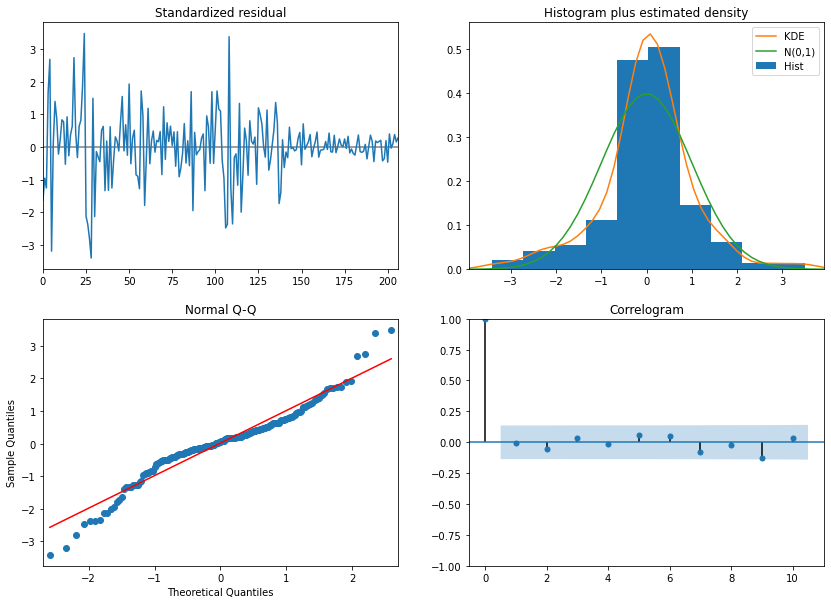

In [114]:
sarima_model1.plot_diagnostics(figsize=(14,10))
plt.show()

## Findings:
We can see from the model plots that the Correlogram does not show any significant correlation in the residuals. The standardized residual plot depicts variance change, which indicates that model variance is not constant over time while the normal Q-Q plot demonstrates that the residuals do not follow a normal distribution. 

To tackle with conditional variance, we will use GARCH model (arch package in python). 

## GARCH



variance of GARCH:

\begin{aligned}

   \sigma^2_{t+1} & = & \omega + \alpha \epsilon_t^2 + \beta \sigma^2_t \\
   \sigma^2_{t+h} & = & \omega + \alpha  E_{t}[\epsilon_{t+h-1}^2] + \beta E_{t}[\sigma^2_{t+h-1}] \, h \geq 2 \\
                  & = & \omega + \left(\alpha  + \beta\right) E_{t}[\sigma^2_{t+h-1}] \, h \geq 2
\end{aligned} 

GARCH(1,1) Model:

\begin{aligned}
   r_t        & =    & \mu + \epsilon_t \\
   \epsilon_t & =    & \sigma_t e_t \\
   \sigma^2_t & =    & \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma^2_{t-1} \\
   e_t        & \sim & N(0,1)
\end{aligned} 

## SARIMA + GARCH

In [117]:
sarima_residuals = sarima_model1.arima_res_.resid
full_residuals = pd.concat([sarima_residuals ,res['diff']])

In [118]:
full_residuals

date
2014-01-15     40.743034
2014-01-22   -113.934164
2014-01-29    -55.315164
2014-02-05    -68.762390
2014-02-12     88.394070
                 ...    
2018-12-03      8.957218
2018-12-10      0.464369
2018-12-17     -9.757065
2018-12-24     18.271663
2018-12-31     29.143506
Length: 259, dtype: float64

In [119]:
train[-1:]

,avg rainfall,avg temperature,avg wind speed,number
date,,,,
2018-01-08,-5.763624,-0.590567,-1.575798,17.0


In [120]:
start_date = train[-1:].index.to_pydatetime()[0]
start_date 

datetime.datetime(2018, 1, 8, 0, 0)

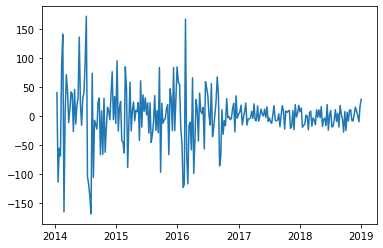

In [121]:
plt.plot(full_residuals)

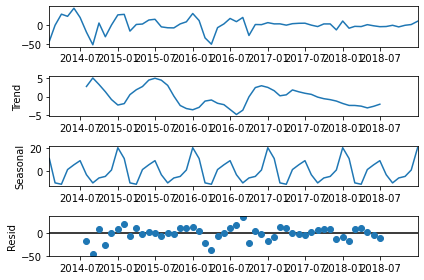

In [122]:
rsd = full_residuals.resample('M').mean()
result = seasonal_decompose(rsd, model='additive') # additive
fig = result.plot()

In [147]:
rsd

date
2014-01-31   -42.835431
2014-02-28    -1.030399
2014-03-31    27.928081
2014-04-30    22.261939
2014-05-31    43.388062
2014-06-30    19.275950
2014-07-31   -19.065228
2014-08-31   -51.872751
2014-09-30     4.840953
2014-10-31   -30.939040
2014-11-30    -0.364273
2014-12-31    26.086307
2015-01-31    27.412134
2015-02-28   -16.247486
2015-03-31     1.083593
2015-04-30     2.201808
2015-05-31    12.663291
2015-06-30    14.565884
2015-07-31    -5.190600
2015-08-31    -7.554098
2015-09-30    -7.886805
2015-10-31     2.540069
2015-11-30     7.962839
2015-12-31    29.626023
2016-01-31    11.294219
2016-02-29   -33.937532
2016-03-31   -50.420782
2016-04-30    -7.244513
2016-05-31     2.530959
2016-06-30    16.700796
2016-07-31     8.397796
2016-08-31    19.383066
2016-09-30   -27.638861
2016-10-31     0.956765
2016-11-30     0.570714
2016-12-31     5.824486
2017-01-31     2.586241
2017-02-28     2.663882
2017-03-31    -0.735829
2017-04-30     3.096127
2017-05-31     4.120433
2017-06-30 

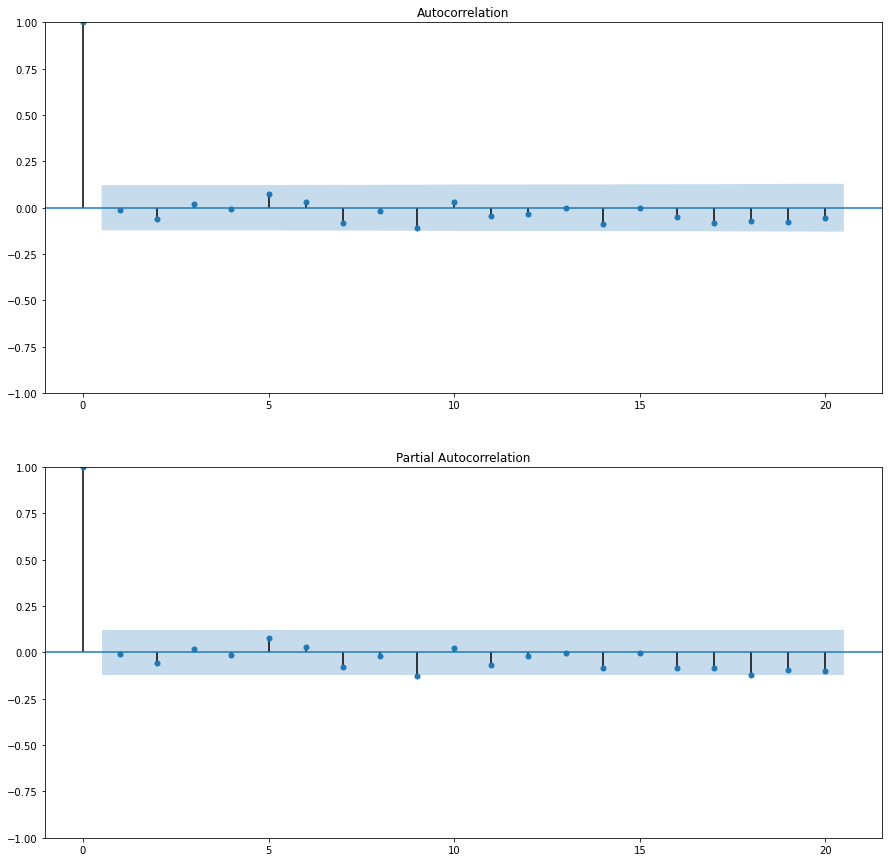

In [123]:
# Generate autocorrelation plot on training data.
fig, ax = plt.subplots(2,1,figsize=(15, 15))
plot_acf(full_residuals, lags = 20,ax=ax[0]);
plot_pacf(full_residuals, lags = 20,ax=ax[1]);

In [164]:
def grid_search_garch(res_data):    
    # Starting AIC, p, o and q.
    best_aic = float('inf')
    best_p = float('inf')
    best_q = float('inf')

    # Use nested for loop to iterate over values of p and q.
    for p in range(1,6):
        for q in range(1,6):
        
            # Instantiate ARIMA model.
            garch = arch_model(res_data, vol='Garch', p=p, q=q, x=exog)
            
            # Fit ARIMA model.
            garch_fitted = garch.fit(last_obs=start_date)

            # Is my current model's AIC better than our best_aic?
            if garch_fitted.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = garch_fitted.aic
                best_p = p
                best_q = q
                best_o = o

    print('MODEL FINISHED!')
    print(f'Our model that minimizes AIC on the training data is the GARCH({best_p}, {best_q}).')
    print(f'This model has an AIC of {best_aic}.')


In [165]:

grid_search_garch(full_residuals)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5787.055927861986
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1046.85881881872
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1045.909806704974
Iteration:      4,   Func. Count:     24,   Neg. LLF: 1045.849192865745
Iteration:      5,   Func. Count:     29,   Neg. LLF: 1045.8233721190459
Iteration:      6,   Func. Count:     34,   Neg. LLF: 1045.8124487187533
Iteration:      7,   Func. Count:     39,   Neg. LLF: 1045.7332483483165
Iteration:      8,   Func. Count:     44,   Neg. LLF: 1045.5227467340465
Iteration:      9,   Func. Count:     49,   Neg. LLF: 1044.9919330256107
Iteration:     10,   Func. Count:     54,   Neg. LLF: 1044.3711110712125
Iteration:     11,   Func. Count:     59,   Neg. LLF: 1043.2779302159997
Iteration:     12,   Func. Count:     64,   Neg. LLF: 1041.8872438119815
Iteration:     13,   Func. Count:     69,   Neg. LLF: 1041.945355937171
Iteration:     14,   Func. Count:     75,   Neg. LLF: 104

In [166]:
# fit a GARCH(1,3) model on the residuals of the ARIMA model
garch = arch_model(full_residuals, vol='Garch', p=1, o=1, q=3, x=exog)
garch_fitted = garch.fit(last_obs=start_date)

# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=test_obs,start=start_date)

Iteration:      1,   Func. Count:      9,   Neg. LLF: 3368.020069579613
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1086.7994056940538
Iteration:      3,   Func. Count:     27,   Neg. LLF: 1042.3912067192027
Iteration:      4,   Func. Count:     36,   Neg. LLF: 1155.5104580473287
Iteration:      5,   Func. Count:     45,   Neg. LLF: 1041.455168454778
Iteration:      6,   Func. Count:     54,   Neg. LLF: 1038.0007512952568
Iteration:      7,   Func. Count:     63,   Neg. LLF: 1035.4477839647077
Iteration:      8,   Func. Count:     71,   Neg. LLF: 1035.3631554218205
Iteration:      9,   Func. Count:     79,   Neg. LLF: 1035.3024668691942
Iteration:     10,   Func. Count:     87,   Neg. LLF: 1035.299901067421
Iteration:     11,   Func. Count:     95,   Neg. LLF: 1035.2993848066214
Iteration:     12,   Func. Count:    103,   Neg. LLF: 1035.2983375733022
Iteration:     13,   Func. Count:    111,   Neg. LLF: 1035.297367046473
Iteration:     14,   Func. Count:    119,   Neg. LLF: 1

In [167]:
print(garch_forecast.mean['h.01'][start_date:])
#print(garch_forecast.mean[start_date:])

date
2018-01-08    2.478043
2018-01-15    2.478043
2018-01-22    2.478043
2018-01-29    2.478043
2018-02-05    2.478043
2018-02-12    2.478043
2018-02-19    2.478043
2018-02-26    2.478043
2018-03-05    2.478043
2018-03-12    2.478043
2018-03-19    2.478043
2018-03-26    2.478043
2018-04-02    2.478043
2018-04-09    2.478043
2018-04-16    2.478043
2018-04-23    2.478043
2018-04-30    2.478043
2018-05-07    2.478043
2018-05-14    2.478043
2018-05-21    2.478043
2018-05-28    2.478043
2018-06-04    2.478043
2018-06-11    2.478043
2018-06-18    2.478043
2018-06-25    2.478043
2018-07-02    2.478043
2018-07-09    2.478043
2018-07-16    2.478043
2018-07-23    2.478043
2018-07-30    2.478043
2018-08-06    2.478043
2018-08-13    2.478043
2018-08-20    2.478043
2018-08-27    2.478043
2018-09-03    2.478043
2018-09-10    2.478043
2018-09-17    2.478043
2018-09-24    2.478043
2018-10-01    2.478043
2018-10-08    2.478043
2018-10-15    2.478043
2018-10-22    2.478043
2018-10-29    2.478043
2018-1

In [135]:
garch_forecast.variance['h.01'].tail()

date
2018-12-03    164.191525
2018-12-10    112.773890
2018-12-17    186.360145
2018-12-24    296.101559
2018-12-31    611.449808
Name: h.01, dtype: float64

In [136]:
garch_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -1035.19
Distribution:                  Normal   AIC:                           2084.38
Method:            Maximum Likelihood   BIC:                           2107.71
                                        No. Observations:                  207
Date:                Sat, Dec 24 2022   Df Residuals:                      206
Time:                        05:04:14   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             2.4780      1.399      1.771  7.657e-02 [ -0.264,  5.221]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         38.0908     21.804      1.747  8.065e-02    [ -4.645, 80.827]
alpha[1]       0.6956      0.245      2.839  4.530e-03    [  0.215,  1.176]
gamma[1]      -0.3872      0.242     -1.599      0.110  [ -0.862,8.731e-02]
beta[1]        0.1233  8.344e-02      1.478      0.139 [-4.021e-02,  0.287]
beta[2]        0.0000  9.021e-02      0.000      1.000    [ -0.177,  0.177]
beta[3]        0.3747      0.113      3.319  9.044e-04    [  0.153,  0.596]
===========================================================================

Covariance estimator: robust
"""

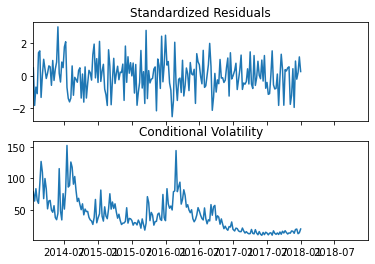

In [137]:
fig = garch_fitted.plot()

In [130]:
# Use ARIMA to predict mu


In [168]:
grid_search_garch(var_res)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 996.5340095575143
Iteration:      2,   Func. Count:     12,   Neg. LLF: 996.1395351499558
Iteration:      3,   Func. Count:     17,   Neg. LLF: 996.0160988889695
Iteration:      4,   Func. Count:     22,   Neg. LLF: 996.0125165541351
Iteration:      5,   Func. Count:     27,   Neg. LLF: 996.0115216253575
Iteration:      6,   Func. Count:     32,   Neg. LLF: 996.0089274272866
Iteration:      7,   Func. Count:     37,   Neg. LLF: 995.9993584792563
Iteration:      8,   Func. Count:     42,   Neg. LLF: 995.9759663329544
Iteration:      9,   Func. Count:     47,   Neg. LLF: 995.9030049584951
Iteration:     10,   Func. Count:     52,   Neg. LLF: 995.6234592548414
Iteration:     11,   Func. Count:     57,   Neg. LLF: 993.9429724087208
Iteration:     12,   Func. Count:     62,   Neg. LLF: 1066.91623552821
Iteration:     13,   Func. Count:     69,   Neg. LLF: 1000.2015502768966
Iteration:     14,   Func. Count:     75,   Neg. LLF: 993.400048

In [169]:
# fit a GARCH(1,2) model on the residuals of the ARIMA model
garch = arch_model(var_res, vol='Garch', p=1, o=1, q=2, x=exog)
garch_fitted = garch.fit(last_obs=start_date)

# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=test_obs,start=start_date)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 3468.653549594235
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1011.2459743693677
Iteration:      3,   Func. Count:     25,   Neg. LLF: 992.1581302408873
Iteration:      4,   Func. Count:     32,   Neg. LLF: 993.0249016000423
Iteration:      5,   Func. Count:     40,   Neg. LLF: 1005.5167967191628
Iteration:      6,   Func. Count:     48,   Neg. LLF: 990.8704024656147
Iteration:      7,   Func. Count:     55,   Neg. LLF: 990.6872213291147
Iteration:      8,   Func. Count:     62,   Neg. LLF: 990.6487694434702
Iteration:      9,   Func. Count:     69,   Neg. LLF: 990.6384847426519
Iteration:     10,   Func. Count:     76,   Neg. LLF: 990.632671536134
Iteration:     11,   Func. Count:     83,   Neg. LLF: 990.6289970157694
Iteration:     12,   Func. Count:     90,   Neg. LLF: 990.6143502790105
Iteration:     13,   Func. Count:     97,   Neg. LLF: 990.5923069877355
Iteration:     14,   Func. Count:    104,   Neg. LLF: 990.52613

In [185]:
garch_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Constant Mean - GJR-GARCH Model Results                    
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -988.014
Distribution:                  Normal   AIC:                           1988.03
Method:            Maximum Likelihood   BIC:                           2007.82
                                        No. Observations:                  200
Date:                Sat, Dec 24 2022   Df Residuals:                      199
Time:                        05:58:49   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1797      1.955  9.189e-02      0.927 [ -3.652,  4.012]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega        210.3686     95.069      2.213  2.691e-02  [ 24.037,3.967e+02]
alpha[1]       0.8244      0.440      1.875  6.077e-02 [-3.727e-02,  1.686]
gamma[1]      -0.2609      0.454     -0.574      0.566    [ -1.151,  0.629]
beta[1]        0.0101  4.972e-02      0.203      0.839 [-8.733e-02,  0.108]
beta[2]        0.2818      0.159      1.774  7.601e-02 [-2.948e-02,  0.593]
===========================================================================

Covariance estimator: robust
"""

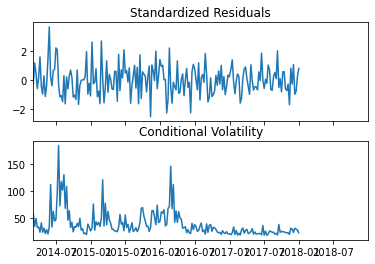

In [186]:
fig = garch_fitted.plot()

In [170]:
print(garch_forecast.mean['h.01'][start_date - dt.timedelta(8):])

date
2017-12-31         NaN
2018-01-08    0.179653
2018-01-15    0.179653
2018-01-22    0.179653
2018-01-29    0.179653
2018-02-05    0.179653
2018-02-12    0.179653
2018-02-19    0.179653
2018-02-26    0.179653
2018-03-05    0.179653
2018-03-12    0.179653
2018-03-19    0.179653
2018-03-26    0.179653
2018-04-02    0.179653
2018-04-09    0.179653
2018-04-16    0.179653
2018-04-23    0.179653
2018-04-30    0.179653
2018-05-07    0.179653
2018-05-14    0.179653
2018-05-21    0.179653
2018-05-28    0.179653
2018-06-04    0.179653
2018-06-11    0.179653
2018-06-18    0.179653
2018-06-25    0.179653
2018-07-02    0.179653
2018-07-09    0.179653
2018-07-16    0.179653
2018-07-23    0.179653
2018-07-30    0.179653
2018-08-06    0.179653
2018-08-13    0.179653
2018-08-20    0.179653
2018-08-27    0.179653
2018-09-03    0.179653
2018-09-10    0.179653
2018-09-17    0.179653
2018-09-24    0.179653
2018-10-01    0.179653
2018-10-08    0.179653
2018-10-15    0.179653
2018-10-22    0.179653
2018-1

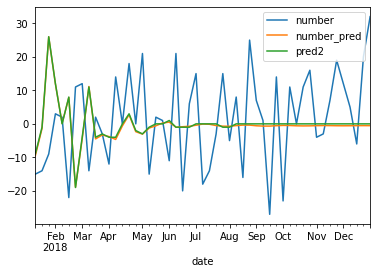

In [184]:
res1['pred2'] = round (res1['number_pred'] + 0.18)
res1[['number','number_pred','pred2']].plot()

In [180]:
pred['number_pred'] = res1['pred2']

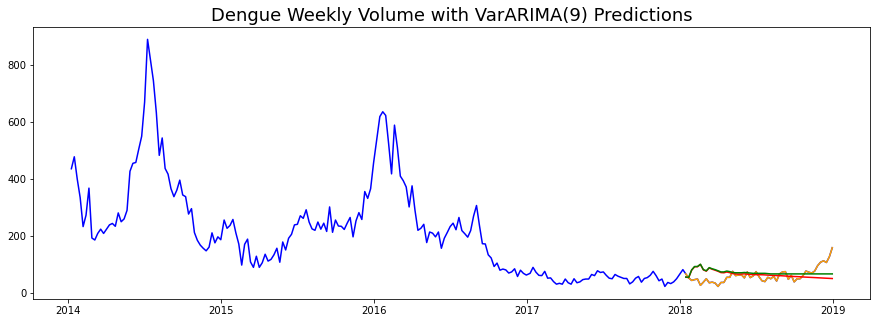

In [183]:
output2 = invert_transformation( df[['avg rainfall','avg temperature','avg wind speed','number']].head(len(df)-test_obs-1), pred)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(df['number'], color = 'blue')
plt.plot(df['number'].tail(test_obs), color = 'orange')
plt.plot(output['number_pred'], color = 'red') 
plt.plot(output2['number_pred'], color = 'green')         
plt.title(label = f'Dengue Weekly Volume with VarARIMA({p}) Predictions', fontsize=18)
plt.show();

In [187]:
mean_squared_error(df['number'][-test_obs:], output2['number_pred'])

1016.8039215686274

In [188]:
print(f" The improvement in mean squared error is {mean_squared_error(df['number'][-test_obs:], output['number_pred'])-mean_squared_error(df['number'][-test_obs:], output2['number_pred'])}")

 The improvement in mean squared error is 153.23653001546563
